## Семинар 6 "Segmentation"

ФИО: Косарев Е.А.

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 26 апреля 2020). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [ ]:
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import torch as t
import imageio
import skimage
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as tsf
import scipy.misc
from skimage import io
from torch.utils import data
import torch.nn.functional as F
import torch.nn as nn
from pathlib import Path
import albumentations as albu
from PIL import Image


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'

In [ ]:
!pip install tifffile 
!pip install imagecodecs 

In [ ]:
import gdal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def process(dataset_path, path_to_masks=None):
    if path_to_masks:
        path_to_masks = Path(path_to_masks)
    data = []
    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        
        img = gdal.Open(str(image)).ReadAsArray().T
        img = img[:,:,:3]
        
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if path_to_masks:
            mask = io.imread(path_to_masks/(item['name'] + "_manual1.gif")).T
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data

In [ ]:
test = process('/content/drive/MyDrive/data_all_hw6/test/images/')
t.save(test, TEST_PATH)
train_data = process('/content/drive/MyDrive/data_all_hw6/train/images', "/content/drive/MyDrive/data_all_hw6/train/1st_manual/")

In [ ]:
import PIL
class Dataset(torch.utils.data.Dataset):
    def __init__(self,data, transforms, pixel_transforms):
        self.datas = data
        self.transforms = transforms
        self.pixel_transforms = pixel_transforms
    
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = (data['mask'][:,:,None]  / 255.).byte().numpy()
        transformed = self.transforms(image = img, mask = mask)
        img = transformed['image']
        img = self.pixel_transforms(image = img)['image']
        mask = transformed['mask']
            
        return img.transpose(2,0,1), mask.transpose(2,0,1)
    
    def __len__(self):
        return len(self.datas)



spatial_transforms = albu.Compose([
    albu.RandomScale(scale_limit = 0.2, p = 0.2),
    albu.RandomCrop(128, 128, always_apply = True),
    albu.Rotate(limit = 180),
    albu.Flip(),
    albu.OpticalDistortion(p=0.2),
    albu.IAAAffine(p=0.2)
])


pixel_transforms = albu.Compose([
    albu.RandomBrightness(),
    albu.RandomContrast(),
    albu.HueSaturationValue(hue_shift_limit = 0, val_shift_limit = 0),
    albu.RandomGamma(p = 0.2)
])

In [ ]:
class Dataset_full_images(torch.utils.data.Dataset):
    def __init__(self,data):
        self.datas = data
    
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = (data['mask'][:,:,None]  / 255.).byte().numpy()
        return img.transpose(2,0,1), mask.transpose(2,0,1)
    
    def __len__(self):
        return len(self.datas)

In [ ]:
dataset_train = Dataset(train_data[:-4], spatial_transforms, pixel_transforms)
dataset_val = Dataset_full_images(train_data[-4:])

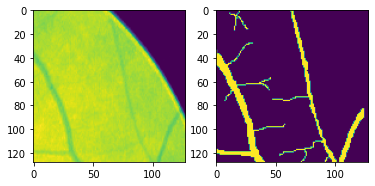

In [ ]:
img, mask = dataset_train[12]
plt.subplot(121)
plt.imshow(img[0])
plt.subplot(122)
plt.imshow(mask[0])

In [ ]:
img.shape

(3, 128, 128)

In [ ]:
mask.shape

(1, 128, 128)

In [ ]:
class convolve_my(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(convolve_my, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class first_cell(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            convolve_my(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class second_sell(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = convolve_my(in_ch, out_ch)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.inc = convolve_my(n_channels, 64)
        self.el1 = first_cell(64, 128)
        self.el2 = first_cell(128, 256)
        self.el3 = first_cell(256, 512)
        self.el4 = first_cell(512, 512)
        self.up1 = second_sell(1024, 256)
        self.up2 = second_sell(512, 128)
        self.up3 = second_sell(256, 64)
        self.up4 = second_sell(128, 64)
        self.outc = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.el1(x1)
        x3 = self.el2(x2)
        x4 = self.el3(x3)
        x5 = self.el4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        first = inputs.view(num,-1)
        second  = targets.view(num,-1)
        score = 2. * ((first * second).sum(1)+1) / (first.sum(1) + second.sum(1)+1)
        score = 1 - score.sum()/num
        return score
    
def my_score(inputs, targets):
        num = targets.size(0)
        first  = inputs.view(num,-1)
        second  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)) / (first.sum(1) + second.sum(1))
        score = (first * second).sum() / num
        return score

In [87]:
device = torch.device('cuda')
model = UNet(3).to(device)

In [88]:
from torchsummary import summary
summary(model, [(3, 128, 128)], batch_size=20)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [20, 64, 128, 128]           1,792
    InstanceNorm2d-2         [20, 64, 128, 128]               0
         LeakyReLU-3         [20, 64, 128, 128]               0
            Conv2d-4         [20, 64, 128, 128]          36,928
    InstanceNorm2d-5         [20, 64, 128, 128]               0
         LeakyReLU-6         [20, 64, 128, 128]               0
       double_conv-7         [20, 64, 128, 128]               0
         MaxPool2d-8           [20, 64, 64, 64]               0
            Conv2d-9          [20, 128, 64, 64]          73,856
   InstanceNorm2d-10          [20, 128, 64, 64]               0
        LeakyReLU-11          [20, 128, 64, 64]               0
           Conv2d-12          [20, 128, 64, 64]         147,584
   InstanceNorm2d-13          [20, 128, 64, 64]               0
        LeakyReLU-14          [20, 128,

In [92]:
dataloaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=30, shuffle=True, num_workers=-1),
    'val': torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=-1)
}

In [ ]:
# Сохранение
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [ ]:
save_checkpoint({'a':3}, './weights/model_0.txt')

In [68]:
best_score = 0.814

In [73]:
from collections import defaultdict
import time
import tqdm
import glob 

def train_model(model, optimizer, scheduler, num_epochs=25):
    global best_score
    print(best_score)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            
            if phase == 'train':
                for num_steps in range(0, 20):
                    for inputs, masks in dataloaders[phase]:
                        imgs = inputs.to(device)
                        masks = masks.to(device)

                        imgs = imgs.float().div(255)
                        masks = masks.float()
                        
                        optimizer.zero_grad()

                        with torch.set_grad_enabled(phase == 'train'):

                            preds = model(imgs)

                            loss = soft_dice_loss(preds, masks)

                            metrics['loss'] += loss.cpu().detach().numpy()

                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        epoch_samples += inputs.size(0)
   
            else:
        
                for inputs, masks in dataloaders[phase]:
                    optimizer.zero_grad()
                    imgs = inputs.to(device).float().div(255)
                    masks = masks.to(device).float()

                    
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(imgs)
                        loss_full = my_score(preds, masks)
                        metrics['loss'] += loss_full.cpu().detach().numpy()

                    epoch_samples += inputs.size(0)

            outputs = []
            for k in metrics.keys():
                outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

            print("{}:\n {}".format(phase, ", ".join(outputs)))
            
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'val' and epoch_loss > best_score:
                
                best_score = epoch_loss
                files = glob.glob('./weights/*')
                for f in files:
                    os.remove(f)
                print("saving best model")
                save_checkpoint({'epoch': epoch,'state_dict': model.state_dict(),
                                 'optimizer' : optimizer.state_dict()},
                               filename='./weights/model_' + str(best_score))
        
        time_elapsed = time.time() - since
        print('{}m {}s'.format(time_elapsed // 60, time_elapsed % 60))
        #scheduler.step()
        
    print('Best val loss: {:4f}'.format(best_score))

In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [98]:
train_model(model, optimizer, scheduler, num_epochs=3000)

0.8242330551147461
Epoch 0/2999
----------
LR 0.001
train:
 loss: 0.031895
val:
 loss: 0.774472
0m 3s
Epoch 1/2999
----------
LR 0.001
train:
 loss: 0.033682
val:
 loss: 0.779592
0m 3s
Epoch 2/2999
----------
LR 0.001
train:
 loss: 0.033302
val:
 loss: 0.774564
0m 3s
Epoch 3/2999
----------
LR 0.001
train:
 loss: 0.031979
val:
 loss: 0.775117
0m 3s
Epoch 4/2999
----------
LR 0.001
train:
 loss: 0.033659
val:
 loss: 0.775231
0m 3s
Epoch 5/2999
----------
LR 0.001
train:
 loss: 0.031767
val:
 loss: 0.772834
0m 3s
Epoch 6/2999
----------
LR 0.001
train:
 loss: 0.032895
val:
 loss: 0.775263
0m 3s
Epoch 7/2999
----------
LR 0.001
train:
 loss: 0.031952
val:
 loss: 0.774905
0m 3s
Epoch 8/2999
----------
LR 0.001
train:
 loss: 0.032985
val:
 loss: 0.774841
0m 3s
Epoch 9/2999
----------
LR 0.001
train:
 loss: 0.033638
val:
 loss: 0.776575
0m 3s
Epoch 10/2999
----------
LR 0.001
train:
 loss: 0.032149
val:
 loss: 0.774076
0m 3s
Epoch 11/2999
----------
LR 0.001
train:
 loss: 0.034131
val:
 loss

KeyboardInterrupt: ignored

In [58]:
model.load_state_dict(torch.load('./weights/' + os.listdir('./weights'))['state_dict'])

<All keys matched successfully>

In [59]:
class TestDataset():
    def __init__(self,path):
        self.datas = t.load(path)
        
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        return img.transpose(2,0,1)
    
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH)
testdataloader = t.utils.data.DataLoader(testset, batch_size=1)

In [63]:
model = model.eval()
for i, data in enumerate(testdataloader):
    pred = model(data.to(device).float().div(255))
    black = pred[0][0].data.cpu().numpy()
    black = (black > 0.5).astype('int').T
    io.imsave("/content/drive/MyDrive/data_all_hw6/test/result/{}.png".format(i + 1), black)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/MyDrive/data_all_hw6/test/result/1.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/MyDrive/data_all_hw6/test/result/2.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/MyDrive/data_all_hw6/test/result/3.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/MyDrive/data_all_hw6/test/result/4.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: /content/drive/MyDrive/data_all_hw6/test/result/5.png is a low contrast image
  # 